In [21]:
import torch

def ada_weighted_mse_loss(target_image, reconstructed_image, zero_weighting, nonzero_weighting):
    """
    Calculates the weighted mean squared error (MSE) loss between target_image and reconstructed_image.
    The loss for zero pixels in the target_image is weighted by zero_weighting, and the loss for non-zero
    pixels is weighted by nonzero_weighting to combat class imbalence.

    Args:
    - target_image: a tensor of shape (B, C, H, W) containing the target image
    - reconstructed_image: a tensor of shape (B, C, H, W) containing the reconstructed image
    - zero_weighting: a scalar weighting coefficient for the MSE loss of zero pixels
    - nonzero_weighting: a scalar weighting coefficient for the MSE loss of non-zero pixels

    Returns:
    - weighted_mse_loss: a scalar tensor containing the weighted MSE loss
    """
    
    # Get the indices of 0 and non 0 values in target_image as a mask for speed
    zero_mask = (target_image == 0)
    nonzero_mask = ~zero_mask         # Invert mask
    
    # Get the values in target_image
    values_zero = target_image[zero_mask]
    values_nonzero = target_image[nonzero_mask]
    
    # Get the corresponding values in reconstructed_image
    corresponding_values_zero = reconstructed_image[zero_mask]
    corresponding_values_nonzero = reconstructed_image[nonzero_mask]
    
    # Create an instance of MSELoss class
    mse_loss = torch.nn.MSELoss()
    
    # Compute the MSE losses
    zero_loss = mse_loss(corresponding_values_zero, values_zero)
    nonzero_loss = mse_loss(corresponding_values_nonzero, values_nonzero)

    # Protection from there being no 0 vals or no non zero vals, which then retunrs nan for MSE and creates a nan overall MSE return (which is error)
    if torch.isnan(zero_loss):
        zero_loss = 0
    if torch.isnan(nonzero_loss):
        nonzero_loss = 0
    
    # Sum losses with weighting coefficiants 
    weighted_mse_loss = (zero_weighting * zero_loss) + (nonzero_weighting * nonzero_loss) 
    
    return weighted_mse_loss


# Example tensors
B, C, H, W = 1, 1, 256, 256                  #Shape of dummy example Tensors
t1 = torch.randn(B, C, H, W).double()
t2 = torch.randn(B, C, H, W).double()



weight_1 = 1
weight_2 = 1

print("ADA SPLIT MSE:", ada_weighted_mse_loss(t1, t2, weight_1, weight_2))

# Testing vs standard non weighted MSELoss
mse_loss = torch.nn.MSELoss()
print("STD MSE: ",mse_loss(t1, t2))

ADA SPLIT MSE: tensor(7.5529, dtype=torch.float64)
STD MSE:  tensor(2.0185, dtype=torch.float64)


TypeError: Invalid shape (10, 2, 128, 88) for image data

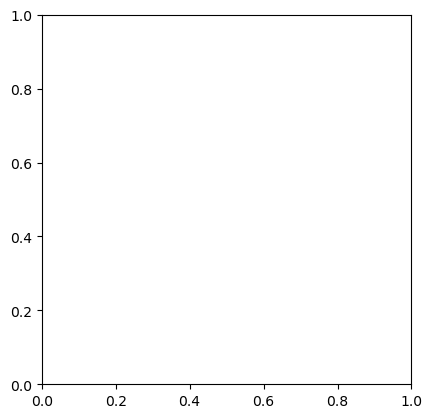

In [45]:
import numpy as np

def generate_image_pairs(height, width, step_size):
    # Generate the original images where im1 has a signal in it of 100 vals and im 2 has half of that signal in it
    img1 = np.zeros((height, width))
    img2 = np.zeros((height, width))
    img1[height//2:, :] = 100    
    img2[height//4:, :] = 50
    
    # Generate a list of image1 and image2 pairs with gradually less signal pixels, but retain the exact same 50% ratio between img1 and img2's signal (100 value) pixels
    test_imgs = [[img1, img2]]
    for i in range(step_size, width+step_size, step_size):
        img1[:, i:] = 0
        img2[:, i//2:] = 0
        test_imgs.append([img1, img2])
        
    return test_imgs

tim = generate_image_pairs(128, 88, step_size=10)
plt.imshow(tim)
plt.show()

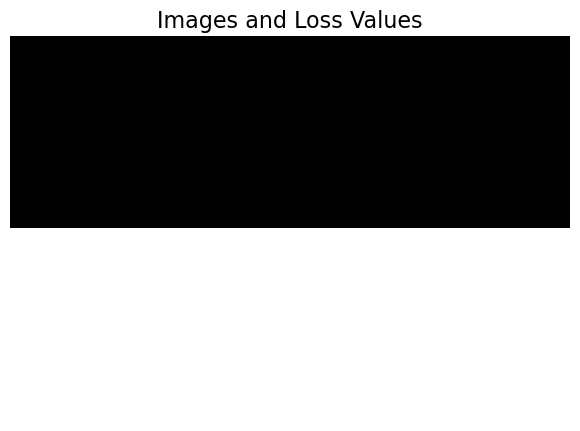

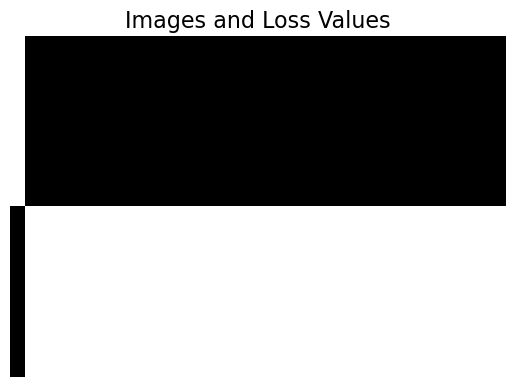

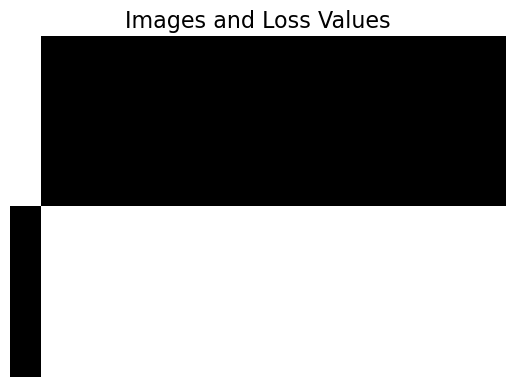

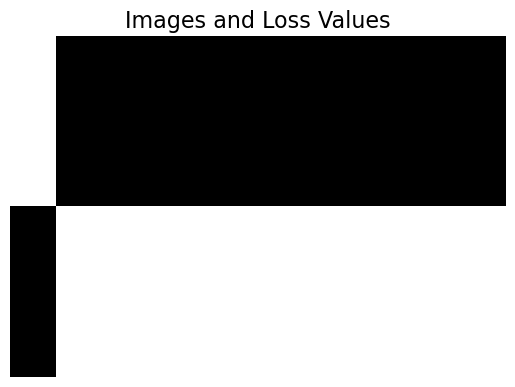

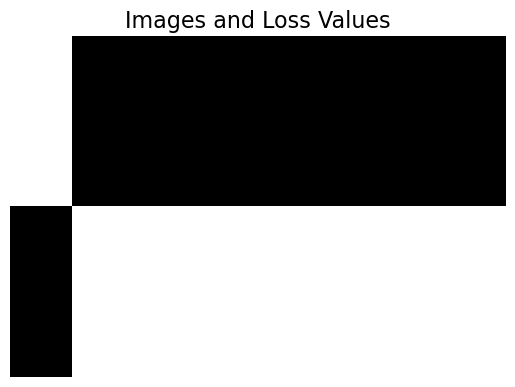

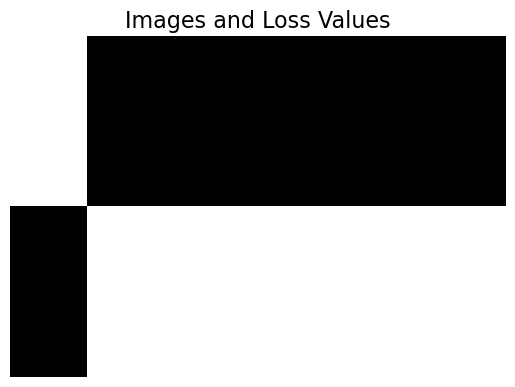

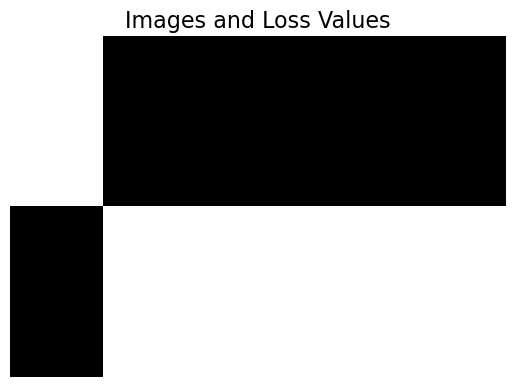

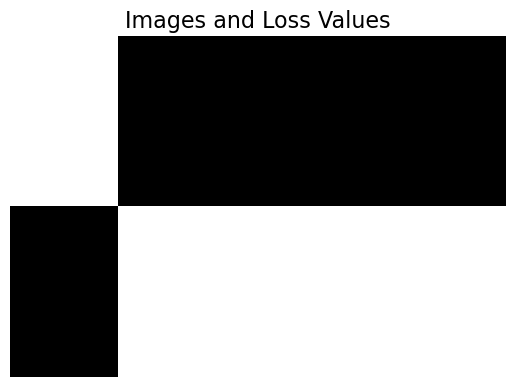

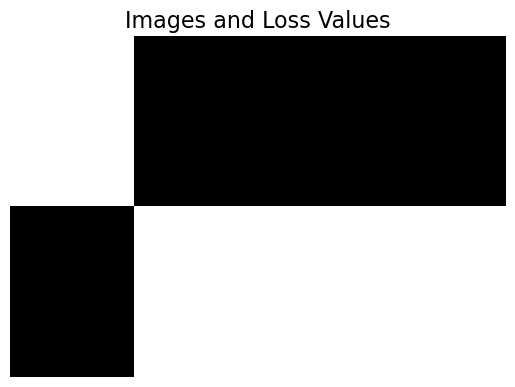

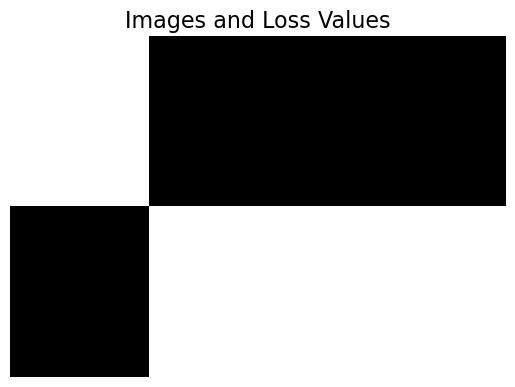

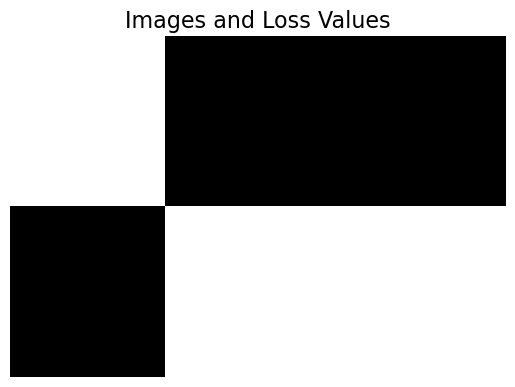

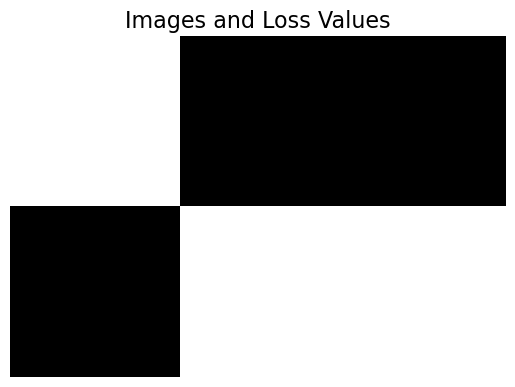

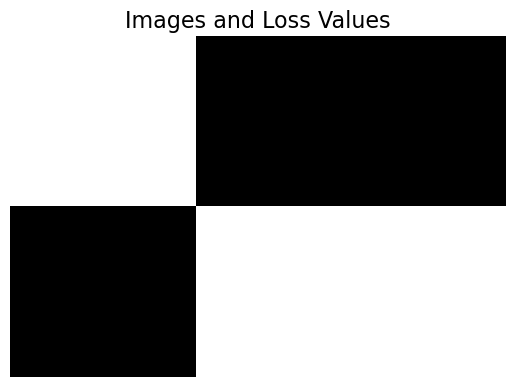

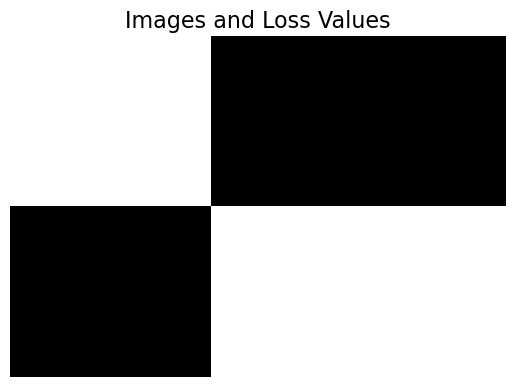

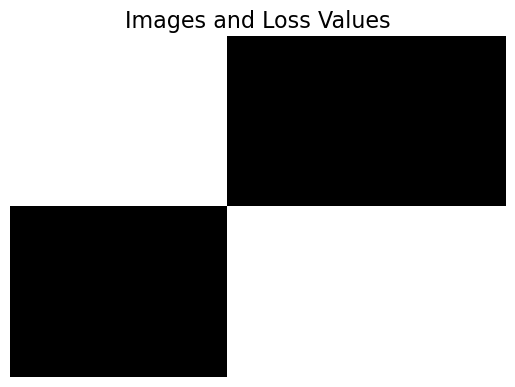

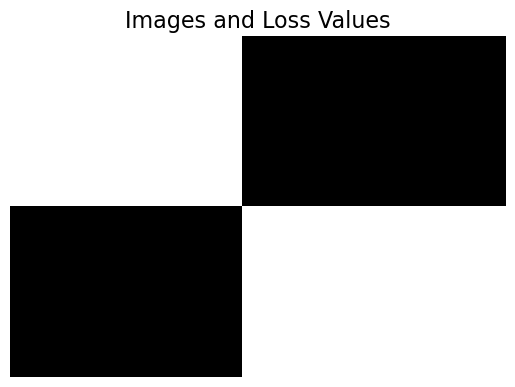

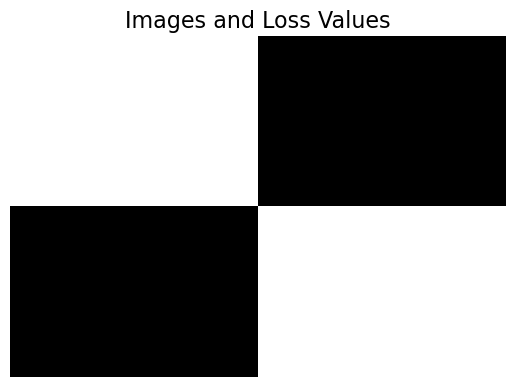

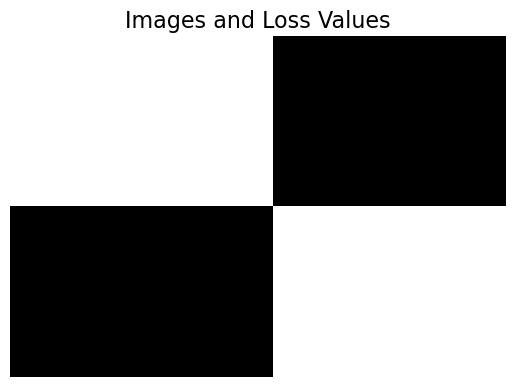

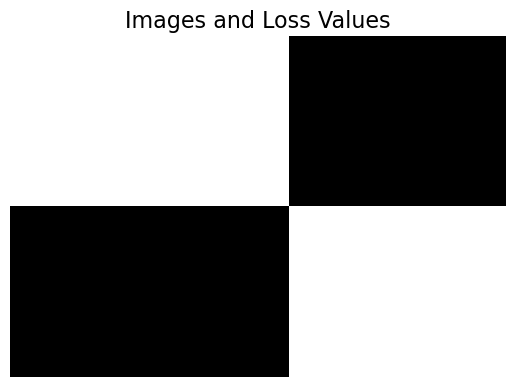

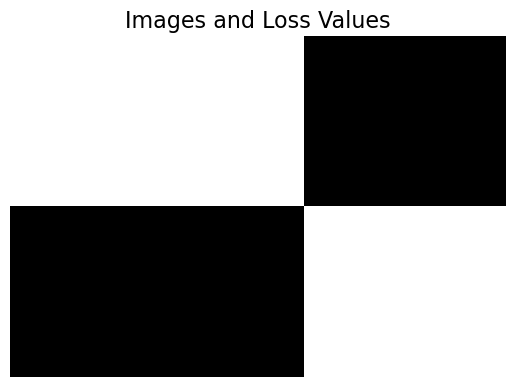

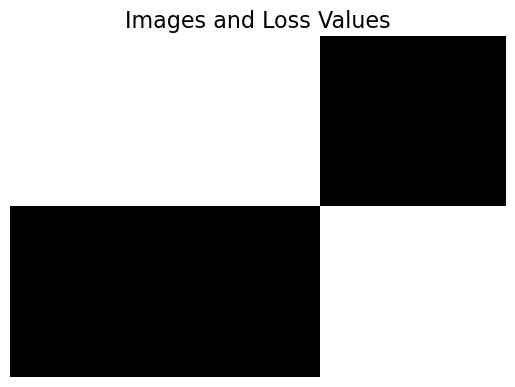

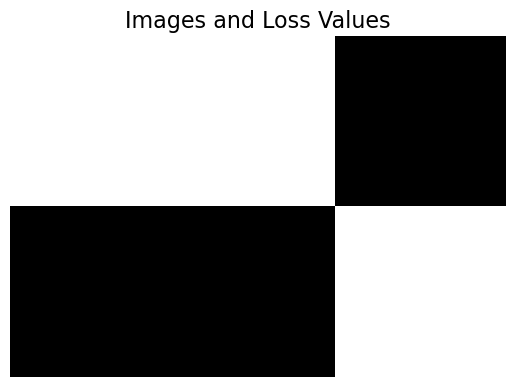

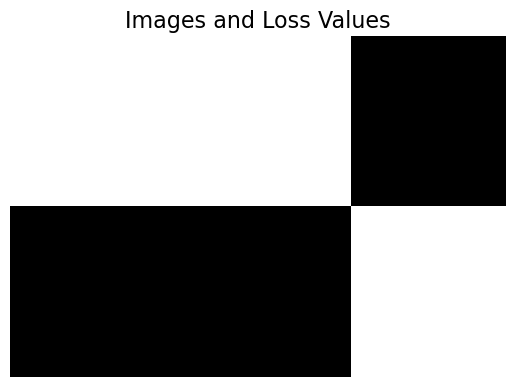

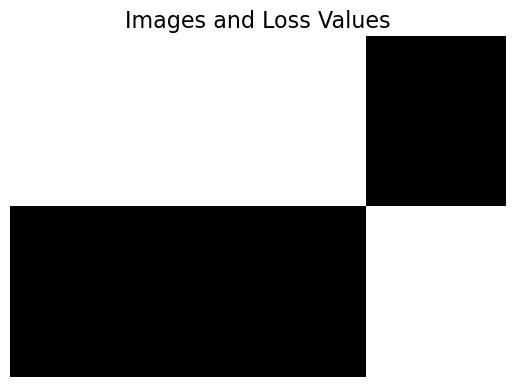

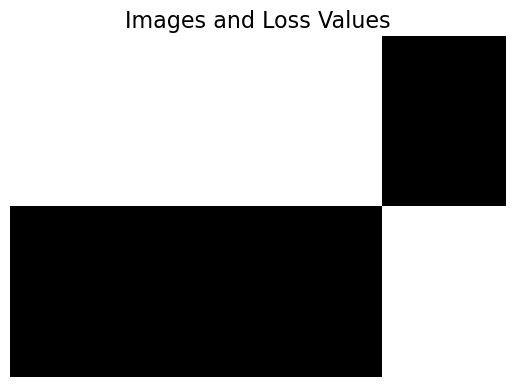

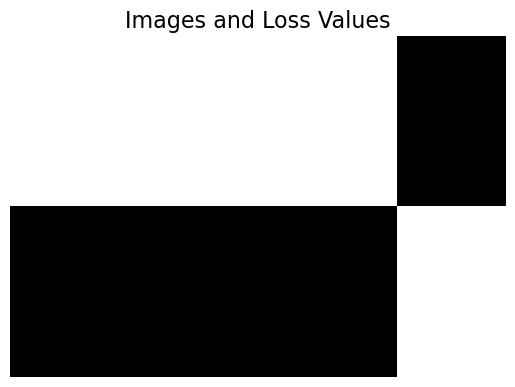

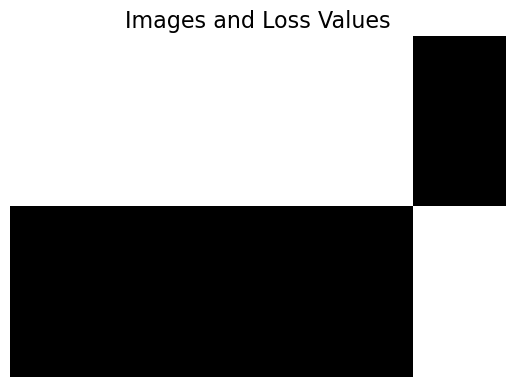

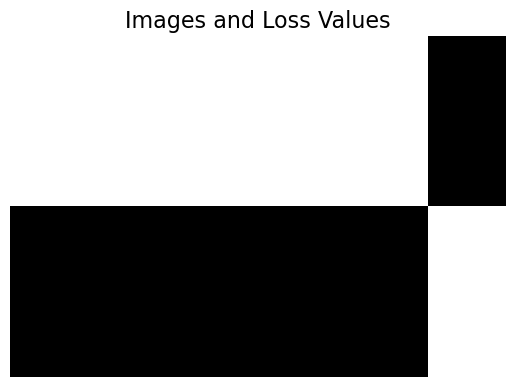

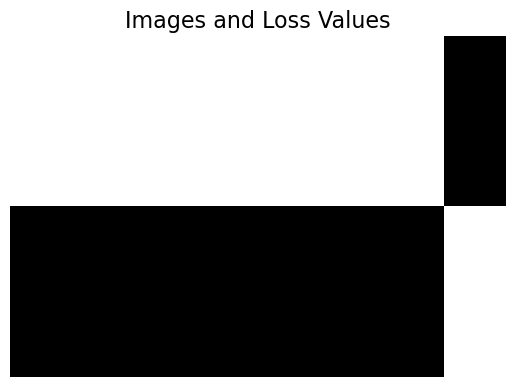

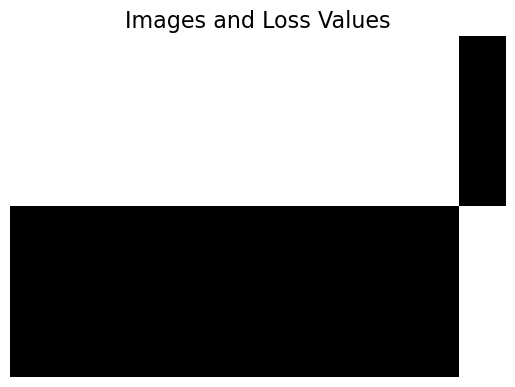

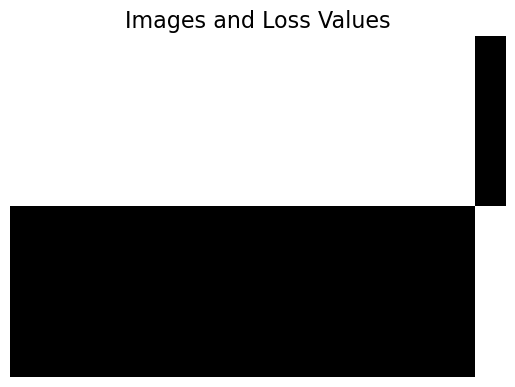

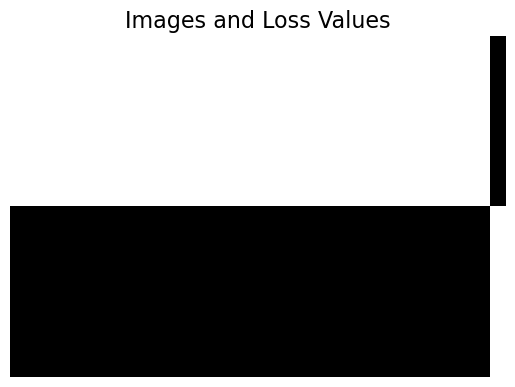

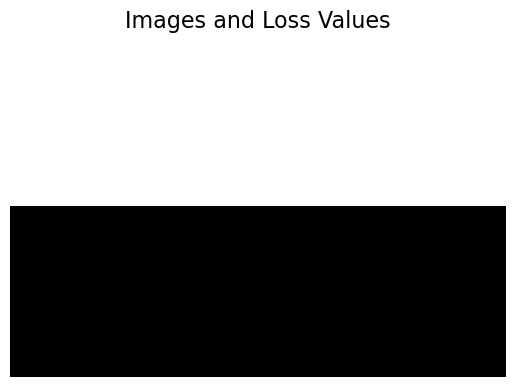

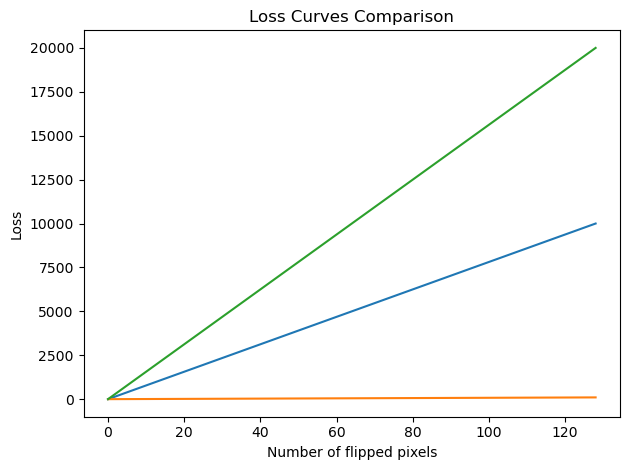

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def generate_test_images(height, width, step_size):
    # Generate the original images where im1 has a signal in it of 100 vals and im 2 has half of that signal in it
    img1 = np.zeros((height, width))
    img2  = np.zeros((height, width))
    img1[height//2:, :] = 100    
    img2[height//4:, :] = 100
    
    # Generate a list of image1 and image2 pairs with gradually less signal pixels, but retain the exact same 50% ratio between img 1 and img2s signal (100 value) pixels
    test_imgs = [[img1, img2]]
    for i in range(step_size, width+step_size, step_size):

        test_imgs.append([im1, im2])
        
    return test_imgs

def calculate_loss(img1, img2):
    # Calculate the mean squared error between the two images
    mse = np.mean(np.square(img1 - img2))
    mae = np.mean(abs(img1-img2))
    wmse = ada_weighted_mse_loss(torch.tensor(img1), torch.tensor(img2), 1, 1)
    return mse, mae, wmse

# Define the image dimensions
height = 88
width = 128

# Define the step size for flipping pixels
step_size = 4

# Generate the test images
test_imgs = generate_test_images(height, width, step_size)

# Calculate the loss for each test image
mse_vals = []
mae_vals = []
wmse_vals = []
for test_img in test_imgs:
    mse, mae, wmse = calculate_loss(test_img[0], test_img[1])
    mse_vals.append(mse)
    mae_vals.append(mae)
    wmse_vals.append(wmse)
    
# Plot the test images and their corresponding loss values
num_imgs = len(test_imgs)
plt.figure(figsize=(12, 5))
for i, (test_img, loss) in enumerate(zip(test_imgs, loss_values)):
    plt.plot(2, num_imgs, i+1)
    plt.imshow(test_img[0], cmap='gray')
    plt.axis('off')
    plt.title(f'Step {i*step_size}\nLoss = {loss:.2f}')
    plt.title('Images and Loss Values', fontsize=16)
    # Show the plot
    plt.show()
    
# Plot the loss curves
plt.plot(np.arange(num_imgs)*step_size, mse_vals)
plt.plot(np.arange(num_imgs)*step_size, mae_vals)
plt.plot(np.arange(num_imgs)*step_size, wmse_vals)
plt.xlabel('Number of flipped pixels')
plt.ylabel('Loss')
plt.title('Loss Curves Comparison')

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()


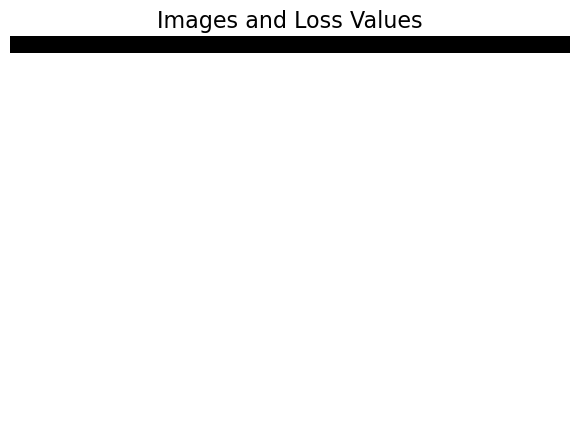

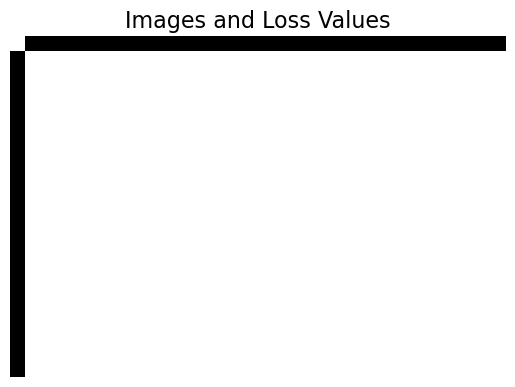

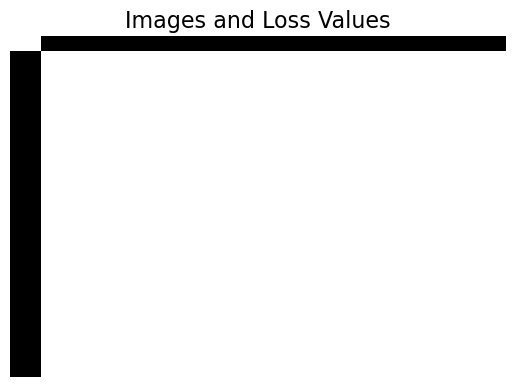

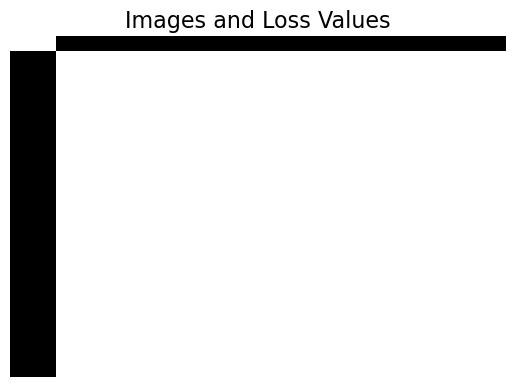

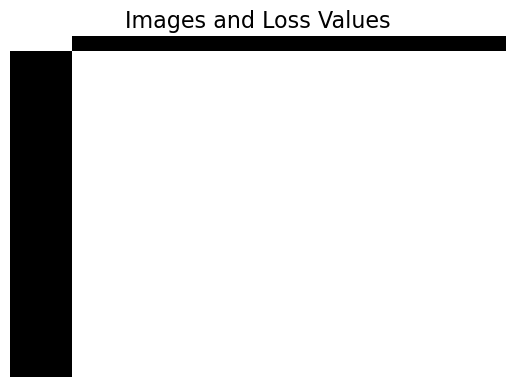

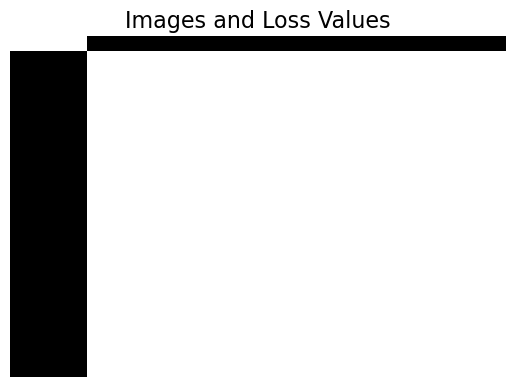

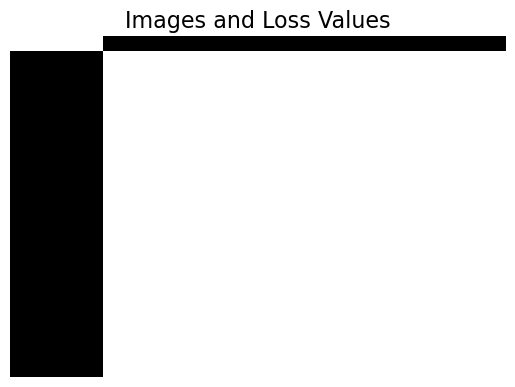

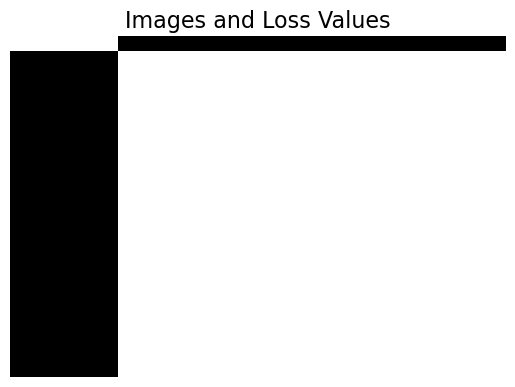

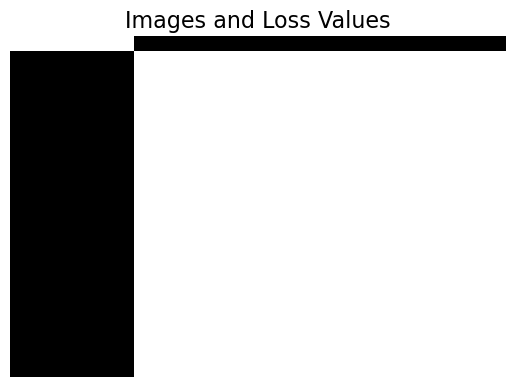

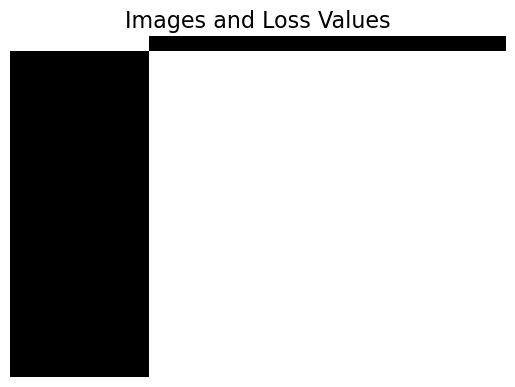

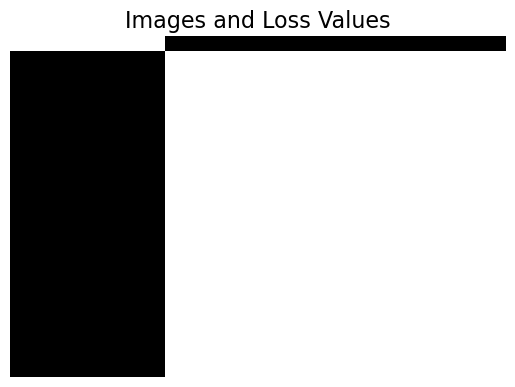

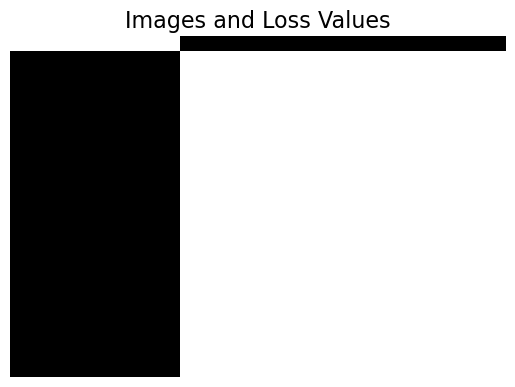

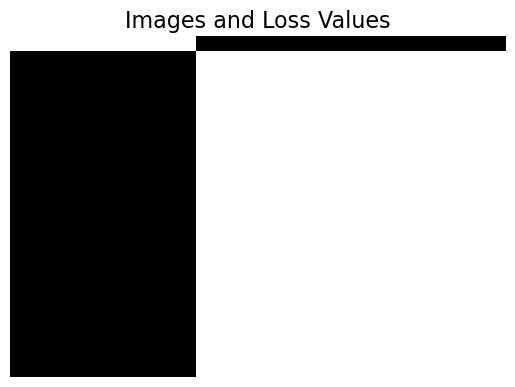

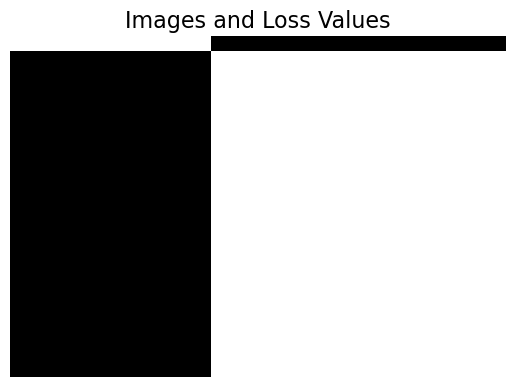

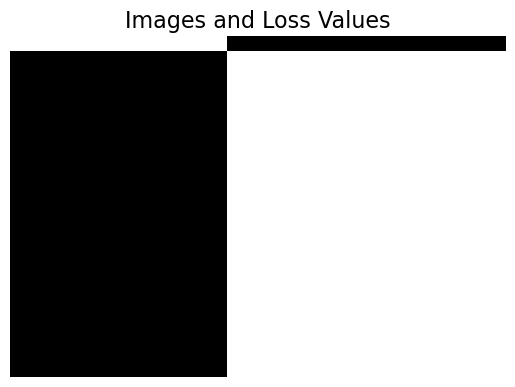

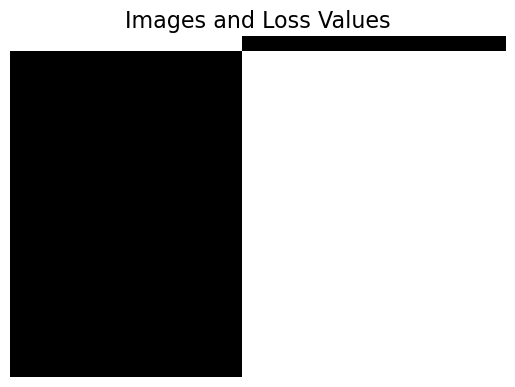

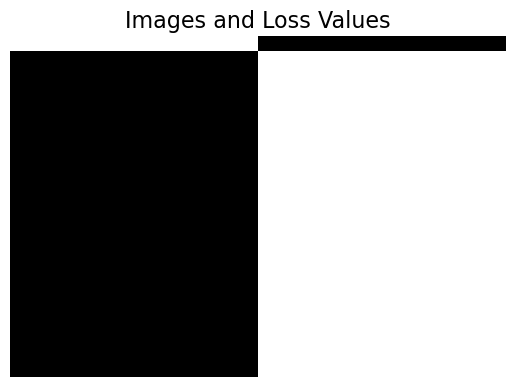

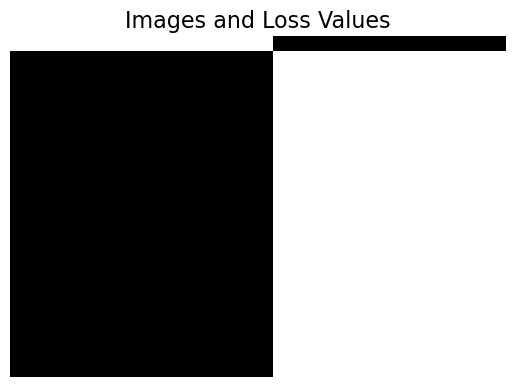

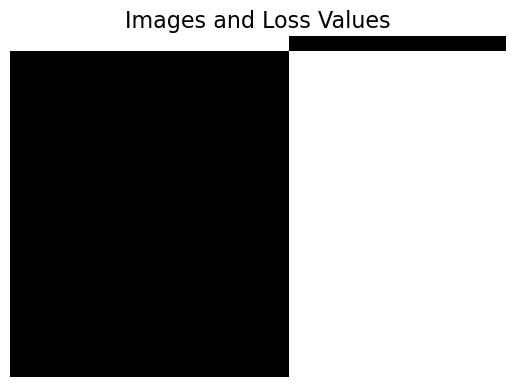

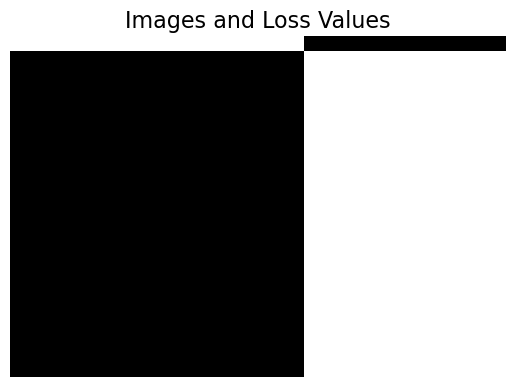

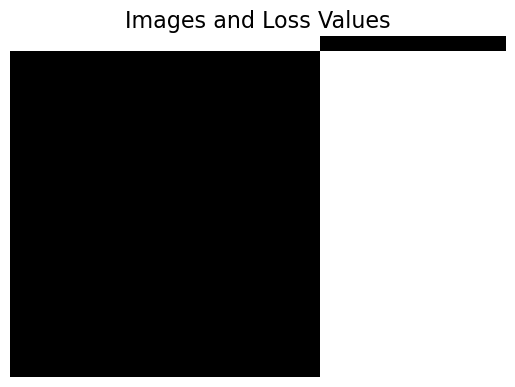

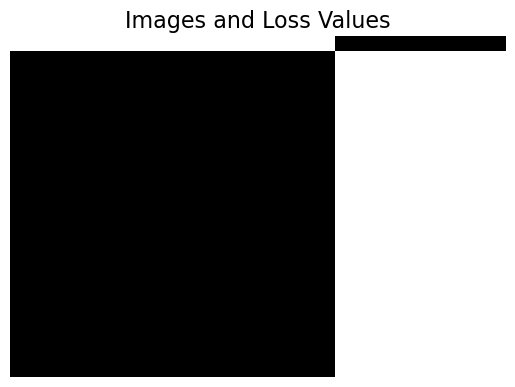

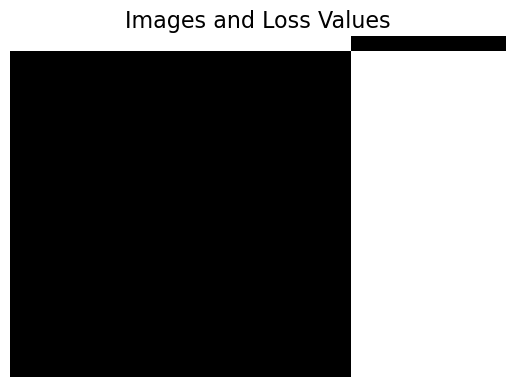

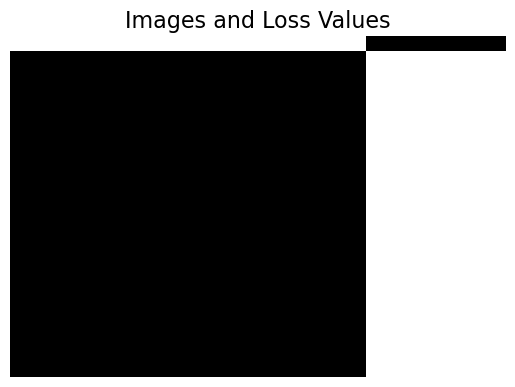

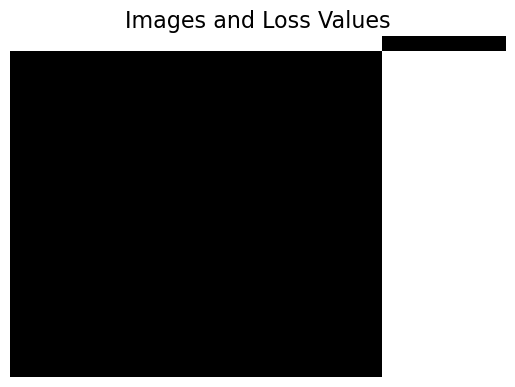

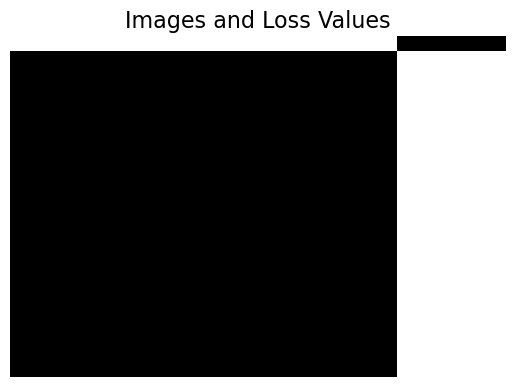

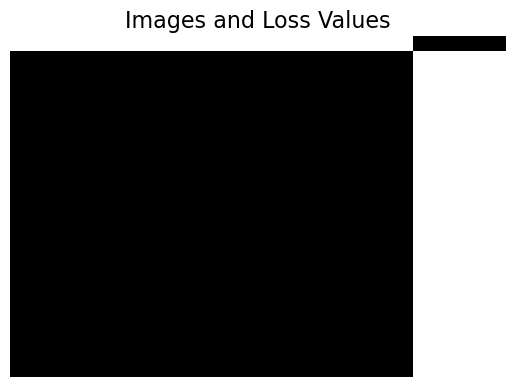

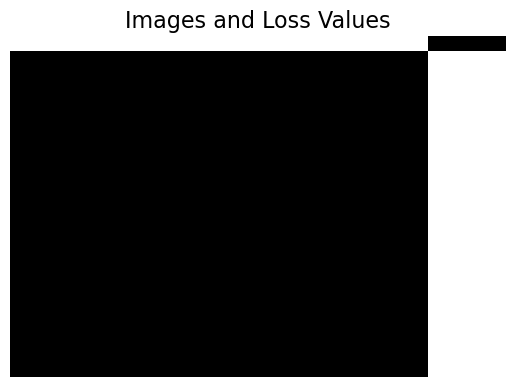

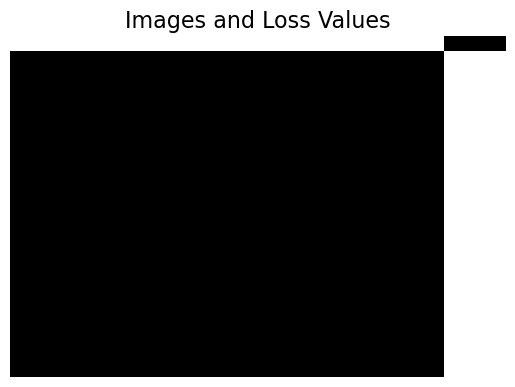

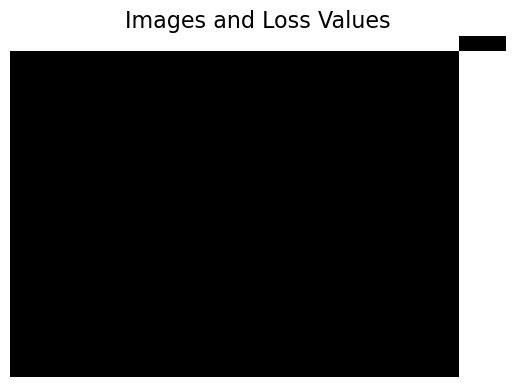

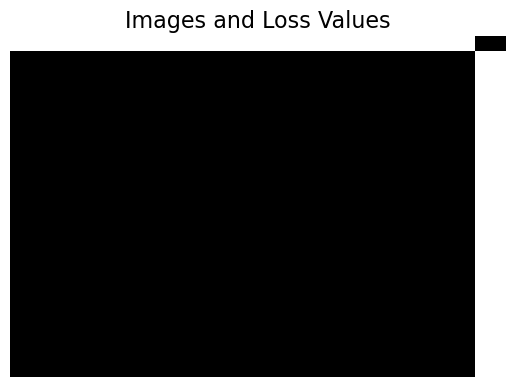

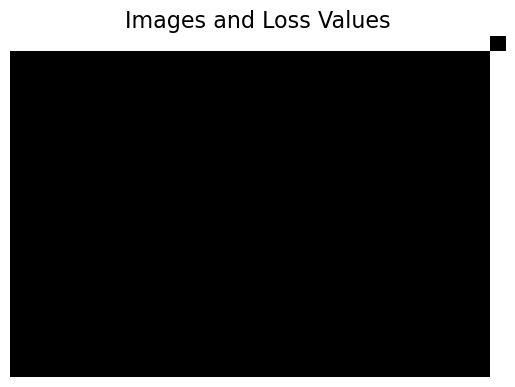

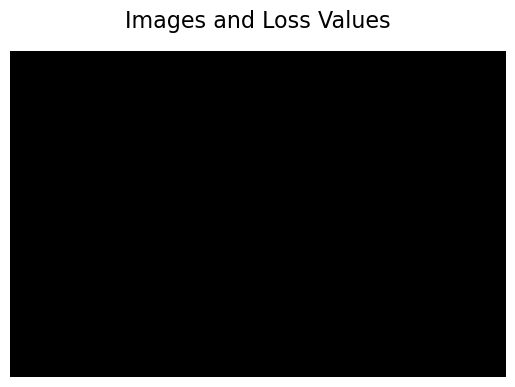

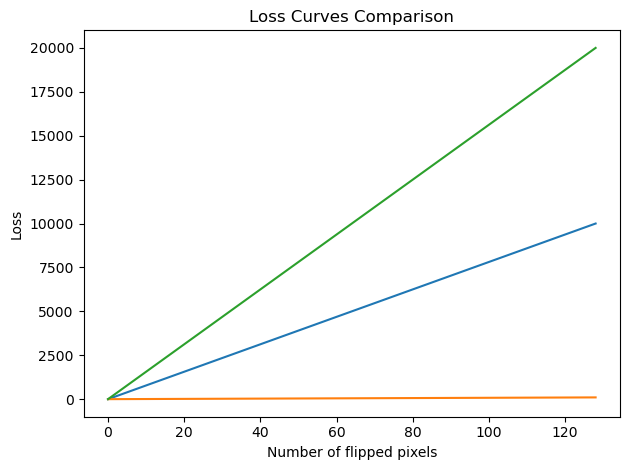

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def generate_test_images(height, width, step_size):
    # Generate the original image with half 0 and half 100
    img1 = np.zeros((height, width))
    img1[height//20:, :] = 100
    
    # Generate the flipped image by inverting the values in the original image
    img2 = 100 - img1
    
    # Generate a list of test images with gradually increasing number of flipped pixels
    test_imgs = [img1]
    for i in range(step_size, width+step_size, step_size):
        flipped_img1 = img1.copy()
        flipped_img1[:, :i] = 100 - flipped_img1[:, :i]
        test_imgs.append(flipped_img1)
        
        #flipped_img2 = img2.copy()
        #flipped_img2[:, :i] = 100 - flipped_img2[:, :i]
        #test_imgs.append(flipped_img2)
    
    return test_imgs

def calculate_loss(img1, img2):
    # Calculate the mean squared error between the two images
    mse = np.mean(np.square(img1 - img2))
    mae = np.mean(abs(img1-img2))
    wmse = ada_weighted_mse_loss(torch.tensor(img1), torch.tensor(img2), 1, 1)
    return mse, mae, wmse

# Define the image dimensions
height = 88
width = 128

# Define the step size for flipping pixels
step_size = 4

# Generate the test images
test_imgs = generate_test_images(height, width, step_size)

# Calculate the loss for each test image
mse_vals = []
mae_vals = []
wmse_vals = []
for test_img in test_imgs:
    mse, mae, wmse = calculate_loss(test_imgs[0], test_img)
    mse_vals.append(mse)
    mae_vals.append(mae)
    wmse_vals.append(wmse)
    
# Plot the test images and their corresponding loss values
num_imgs = len(test_imgs)
plt.figure(figsize=(12, 5))
for i, (test_img, loss) in enumerate(zip(test_imgs, loss_values)):
    plt.plot(2, num_imgs, i+1)
    plt.imshow(test_img, cmap='gray')
    plt.axis('off')
    plt.title(f'Step {i*step_size}\nLoss = {loss:.2f}')
    plt.title('Images and Loss Values', fontsize=16)
    # Show the plot
    plt.show()
    
# Plot the loss curves
plt.plot(np.arange(num_imgs)*step_size, mse_vals)
plt.plot(np.arange(num_imgs)*step_size, mae_vals)
plt.plot(np.arange(num_imgs)*step_size, wmse_vals)
plt.xlabel('Number of flipped pixels')
plt.ylabel('Loss')
plt.title('Loss Curves Comparison')

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()


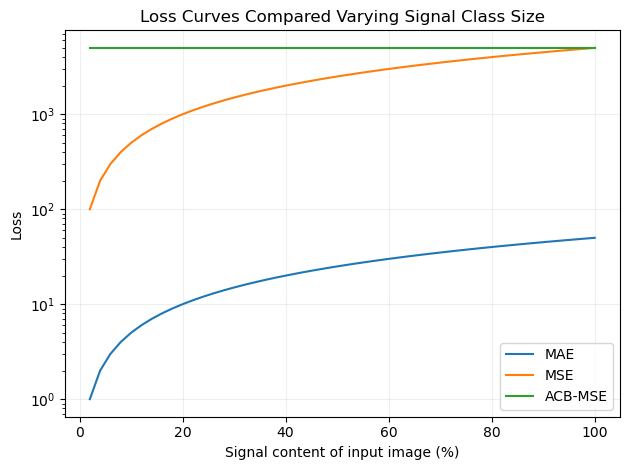

In [179]:
import numpy as np

#####signal getting smaller but retaining ratio!! 

def generate_arrays(n, s, p):
    # First array
    array1 = np.zeros(n)
    array1[:s] = 100

    # Second array
    array2 = np.zeros(n)
    array2[:int(s * p)] = 100
    
    return array1, array2

def calculate_loss(img1, img2):
    # Calculate the mean squared error between the two images
    mse = np.mean(np.square(img1 - img2))
    mae = np.mean(abs(img1-img2))
    wmse = ada_weighted_mse_loss(torch.tensor(img1), torch.tensor(img2), 1, 1)
    return mse, mae, wmse

n = 100
p = 0.5

mse_vals = []
mae_vals = []
wmse_vals = []
s_vals = []
for s in range(2, n+int(1/p), int(1/p)):
    array1, array2 = generate_arrays(n, s, p)
    #print(f"s={s}, array1={array1}, array2={array2}")
    mse, mae, wmse = calculate_loss(array1, array2)
    mse_vals.append(mse)
    mae_vals.append(mae)
    wmse_vals.append(wmse)
    s_vals.append(s)
    
s_vals = np.array(s_vals)/n * 100
        
# Plot the loss curves
plt.plot(s_vals, mae_vals, label="MAE")
plt.plot(s_vals, mse_vals, label="MSE")
plt.plot(s_vals, wmse_vals, label="ACB-MSE")
plt.xlabel('Signal content of input image (%)')
plt.ylabel('Loss')
plt.title('Loss Curves Compared Varying Signal Class Size')
plt.legend()
plt.grid(alpha=0.2)


# Set the x-axis to logarithmic scale
plt.yscale('log')

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()


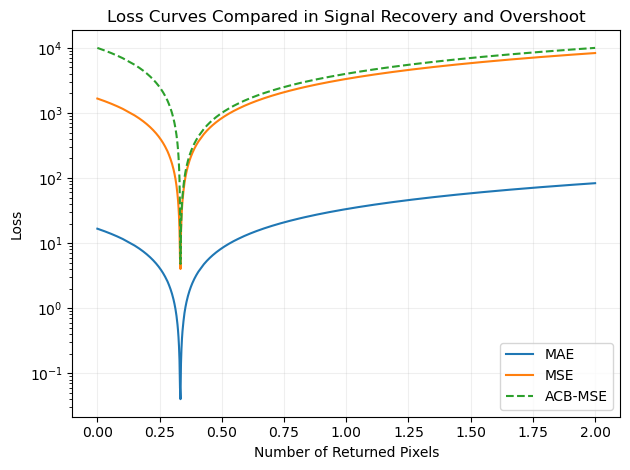

In [181]:
import numpy as np

#####signal ratio getting smaller!! 

def generate_arrays(n, s, p):
    # First array
    array1 = np.zeros(n)
    array1[:n//6] = 100

    # Second array
    array2 = np.zeros(n)
    array2[:int(s * p)] = 100
    
    return array1, array2

def calculate_loss(img1, img2):
    # Calculate the mean squared error between the two images
    mse = np.mean(np.square(img1 - img2))
    mae = np.mean(abs(img1-img2))
    wmse = ada_weighted_mse_loss(torch.tensor(img1), torch.tensor(img2), 1, 1)
    return mse, mae, wmse



n = 10000
s = 5000


mse_vals = []
mae_vals = []
wmse_vals = []
p_vals = []
for p in range(0, 2002, 2):
    p = p/1000
    array1, array2 = generate_arrays(n, s, p)
    #print(f"s={s}, array1={array1}, array2={array2}")
    mse, mae, wmse = calculate_loss(array1, array2)
    mse_vals.append(mse)
    mae_vals.append(mae)
    wmse_vals.append(wmse)
    p_vals.append(p)
    
    
        
# Plot the loss curves
plt.plot(p_vals, mae_vals, label="MAE")
plt.plot(p_vals, mse_vals, label="MSE")
plt.plot(p_vals, wmse_vals, label="ACB-MSE", linestyle="--")
plt.xlabel('Number of Returned Pixels')
plt.ylabel('Loss')
plt.title('Loss Curves Compared in Signal Recovery and Overshoot')
plt.legend()
plt.grid(alpha=0.2)

# Set the x-axis to logarithmic scale
plt.yscale('log')


# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
and has the effect of punishing the network from not making a guess, 

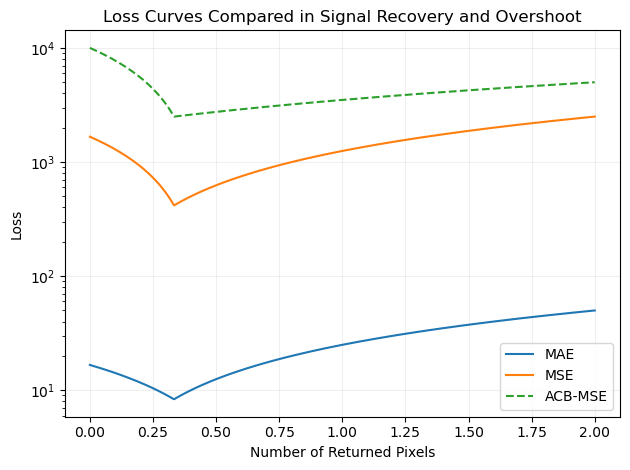

In [192]:
import numpy as np

#####signal ratio getting smaller!! 

def generate_arrays(n, s, p):
    # First array
    array1 = np.zeros(n)
    array1[:n//6] = 100

    # Second array
    array2 = np.zeros(n)
    array2[:int(s * p)] = 50
    
    return array1, array2

def calculate_loss(img1, img2):
    # Calculate the mean squared error between the two images
    mse = np.mean(np.square(img1 - img2))
    mae = np.mean(abs(img1-img2))
    wmse = ada_weighted_mse_loss(torch.tensor(img1), torch.tensor(img2), 1, 1)
    return mse, mae, wmse



n = 10000
s = 5000


mse_vals = []
mae_vals = []
wmse_vals = []
p_vals = []
for p in range(0, 2002, 2):
    p = p/1000
    array1, array2 = generate_arrays(n, s, p)
    #print(f"s={s}, array1={array1}, array2={array2}")
    mse, mae, wmse = calculate_loss(array1, array2)
    mse_vals.append(mse)
    mae_vals.append(mae)
    wmse_vals.append(wmse)
    p_vals.append(p)
    
    
        
# Plot the loss curves
plt.plot(p_vals, mae_vals, label="MAE")
plt.plot(p_vals, mse_vals, label="MSE")
plt.plot(p_vals, wmse_vals, label="ACB-MSE", linestyle="--")
plt.xlabel('Number of Returned Pixels')
plt.ylabel('Loss')
plt.title('Loss Curves Compared in Signal Recovery and Overshoot')
plt.legend()
plt.grid(alpha=0.2)

# Set the x-axis to logarithmic scale
plt.yscale('log')


# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()

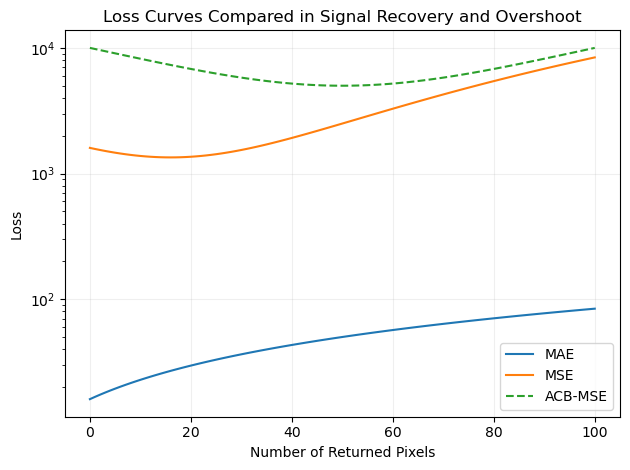

In [191]:
import numpy as np

#####signal ratio getting smaller!! 

def generate_arrays(n, ToF):
    # First array
    array1 = np.zeros(n)
    array1[:n//6] = 100

    # Second array
    array2 = np.zeros(n) + ToF
    #array2[:n//6] = ToF
    
    return array1, array2

def calculate_loss(img1, img2):
    # Calculate the mean squared error between the two images
    mse = np.mean(np.square(img1 - img2))
    mae = np.mean(abs(img1-img2))
    wmse = ada_weighted_mse_loss(torch.tensor(img1), torch.tensor(img2), 1, 1)
    return mse, mae, wmse



n = 100



mse_vals = []
mae_vals = []
wmse_vals = []
ToF_vals = []
for ToF in range(0, 101, 1):
    array1, array2 = generate_arrays(n, ToF)
    #print(f"s={s}, array1={array1}, array2={array2}")
    mse, mae, wmse = calculate_loss(array1, array2)
    mse_vals.append(mse)
    mae_vals.append(mae)
    wmse_vals.append(wmse)
    ToF_vals.append(ToF)
    
    
        
# Plot the loss curves
plt.plot(ToF_vals, mae_vals, label="MAE")
plt.plot(ToF_vals, mse_vals, label="MSE")
plt.plot(ToF_vals, wmse_vals, label="ACB-MSE", linestyle="--")
plt.xlabel('Number of Returned Pixels')
plt.ylabel('Loss')
plt.title('Loss Curves Compared in Signal Recovery and Overshoot')
plt.legend()
plt.grid(alpha=0.2)

# Set the x-axis to logarithmic scale
plt.yscale('log')


# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()
